### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSBSSSSB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12127
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    196.9| 32.3178| -84.5203|       TMAX|USC00091372|    23|[A0 57 00 58 00 5...|1959.0|BSBSSSSB|
|    196.9| 32.3178| -84.5203|       TMAX|USC00091372|    15|[30 55 30 54 B8 5...|1960.0|BSBSSSSB|
|    196.9| 32.3178| -84.5203|       TMAX|USC00091372|    16|[38 59 A0 57 90 5...|1961.0|BSBSSSSB|
|    196.9| 32.3178| -84.5203|       TMAX|USC00091372|    29|[28 58 F0 56 B0 5...|1963.0|BSBSSSSB|
|    196.9| 32.3178| -84.5203|       TMAX|USC00091372|     3|[00 46 F0 56 90 5...|1964.0|BSBSSSSB|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [2]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' "%('PRCP')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(5)

SELECT * FROM weather
	WHERE measurement='PRCP' 
2931 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    170.4| 32.8161| -85.1733|       PRCP|US1ALCB0004|     2|[00 00 E0 5C 00 0...|2011.0|BSBSSSSB|
|    170.4| 32.8161| -85.1733|       PRCP|US1ALCB0004|     3|[00 00 00 00 00 0...|2012.0|BSBSSSSB|
|    118.9| 32.5167| -85.0667|       PRCP|USC00016397|     3|[00 00 00 00 00 0...|1958.0|BSBSSSSB|
|     66.1|   32.15| -85.0667|       PRCP|USC00011974|     1|[00 00 00 00 60 5...|1960.0|BSBSSSSB|
|     66.1|   32.15| -85.0667|       PRCP|USC00011974|     1|[90 59 00 00 00 0...|1961.0|BSBSSSSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



In [3]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00017025')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00017025'
52 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    228.6| 33.1581| -85.2911|       PRCP|USC00017025|     2|[00 00 00 00 00 0...|1939.0|BSBSSSSB|
|    228.6| 33.1581| -85.2911|       PRCP|USC00017025|     0|[00 00 00 00 00 0...|1940.0|BSBSSSSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(52, 365)

### Script for plotting yearly plots

In [4]:
# ORIGINALITY: Added functionality to YearPlotter to include axes labels, legends

from datetime import date
from numpy import shape
from matplotlib.dates import MonthLocator, DateFormatter
class YearPlotterModified:
    def __init__(self):
        start=365*1+1
        self.dates=[date.fromordinal(i) for i in range(start,start+365)]
        self.monthsFmt = DateFormatter("%b")
        self.months = MonthLocator(range(1, 13), bymonthday=1, interval=3)
        #self.i=0

    def plot(self,T,fig,ax,label='',labels=None,title=None,xlabel=None,ylabel=None):
        #print self.i,'fig=',fig,'ax=',ax
        #self.i+=1
        shp=shape(T)
        if shp[0] != 365:
            raise ValueError("First dimension of T should be 365. Shape(T)="+str(shape(T)))
        if len(shp)==1:
            #print 'one'
            ax.plot(self.dates,T,label=label);
        else:
            #print 'more than 1'
            if labels is None:
                labels=[str(i) for i in range(shp[1])]
            for i in range(shp[1]):
                ax.plot(self.dates,T[:,i],label=labels[i])
        ax.xaxis.set_major_locator(self.months)
        ax.xaxis.set_major_formatter(self.monthsFmt)
        if not title is None:
            ax.set_title(title)
        if not xlabel is None:
            ax.set_xlabel(xlabel)
        if not ylabel is None:
            ax.set_ylabel(ylabel)
        #rotate and align the tick labels so they look better
        fig.autofmt_xdate()
        ax.grid()
        ax.legend()

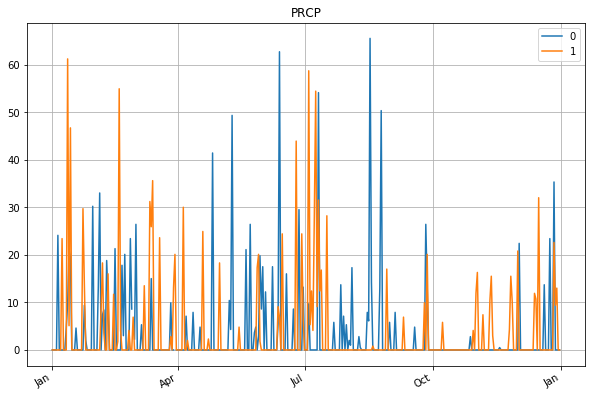

In [5]:
# from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotterModified()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [6]:
# ORIGINALITY:
# Adding functionality to provide custom legend, axes labels.
# Adding functionality to plot single observation as well (plot_single function)
def plot_pair(pair,func,xlabel= None,ylabel= None):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis,xlabel,ylabel)
        
def plot_single(Obs,func,xlabel,ylabel):
    fig = plt.figure()
    fig.set_size_inches(8, 6)
    axis = fig.add_subplot(111)
    func(Obs,fig,axis,xlabel,ylabel)
        
def plot_valid(m,fig,axis,xl,yl):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m,xlabel = xl, ylabel = yl)
    

/root/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


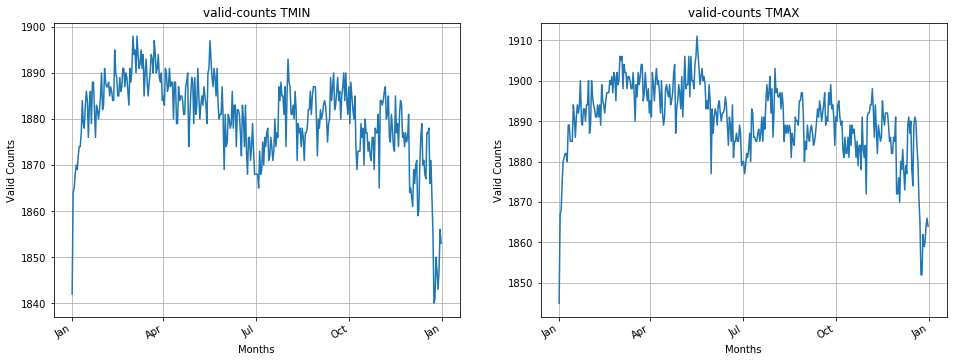

In [7]:
plot_pair(['TMIN','TMAX'],plot_valid,'Months', 'Valid Counts')

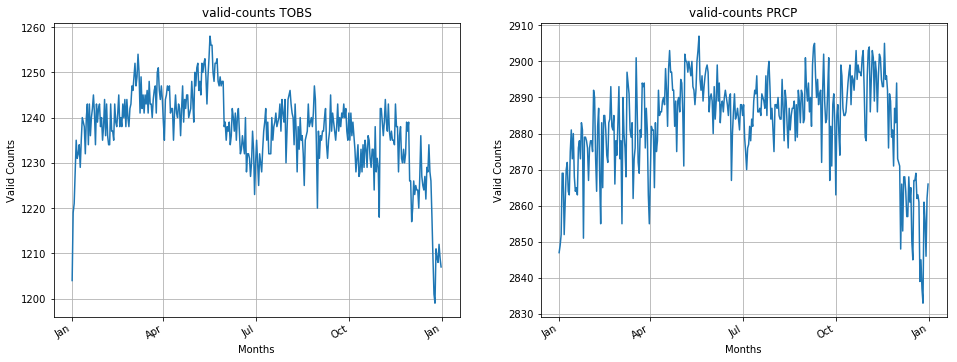

In [8]:
plot_pair(['TOBS','PRCP'],plot_valid,'Months', 'Valid Counts' )

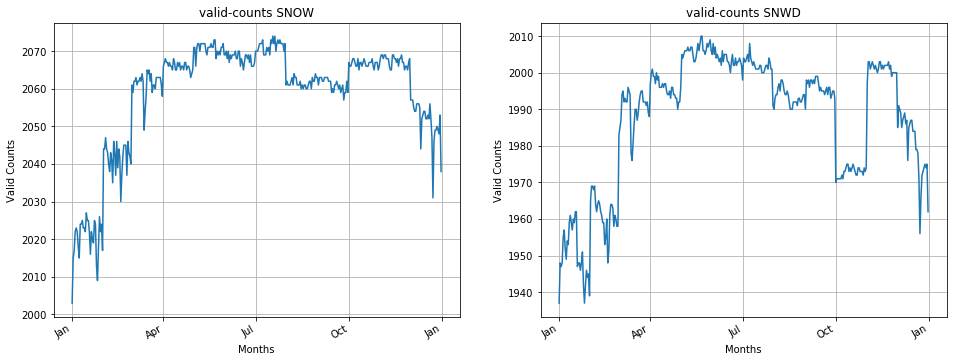

In [9]:
plot_pair(['SNOW', 'SNWD'],plot_valid,'Months', 'Valid Counts')

### Plots of mean and std of observations

In [10]:
def plot_mean_std(m,fig,axis,xl,yl):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([(mean-std)/10,(mean)/10,(mean+std)/10]).transpose()
    YP.plot(graphs,fig,axis,labels=['MEAN-STD','MEAN','MEAN+STD'],title='Mean+-std   '+m, xlabel = xl, ylabel = yl)

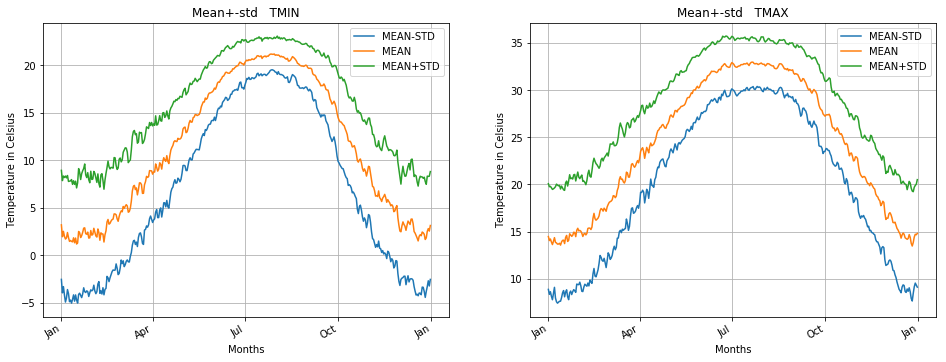

In [11]:
plot_pair(['TMIN','TMAX'],plot_mean_std,'Months','Temperature in Celsius')

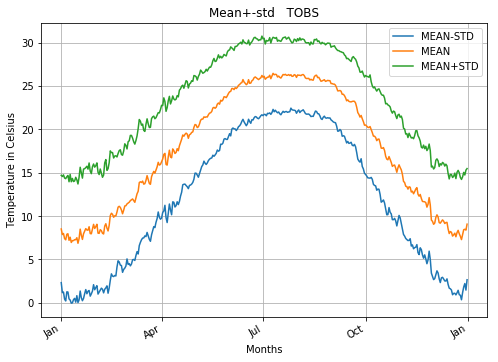

In [12]:
plot_single('TOBS',plot_mean_std,'Months','Temperature in Celsius')

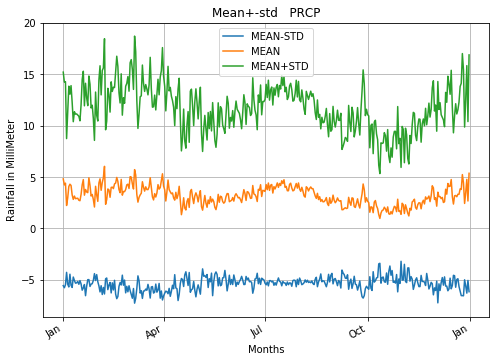

In [13]:
plot_single('PRCP',plot_mean_std,'Months','Rainfall in MilliMeter')

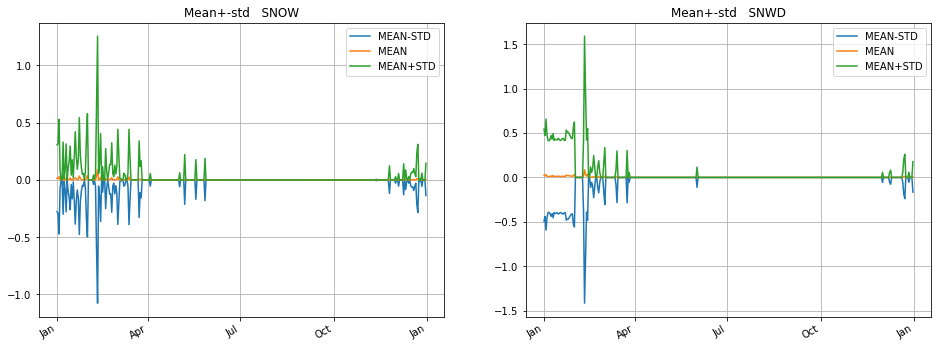

In [14]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [15]:
def plot_eigen(m,fig,axis,xlabel=None, ylabel=None):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

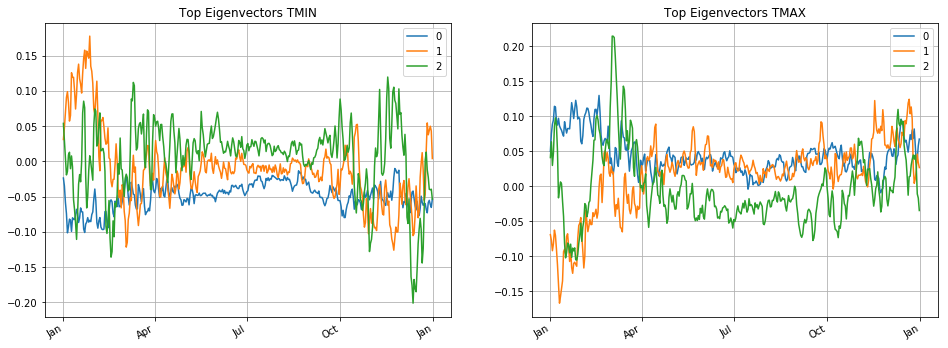

In [16]:
plot_pair(['TMIN','TMAX'],plot_eigen)

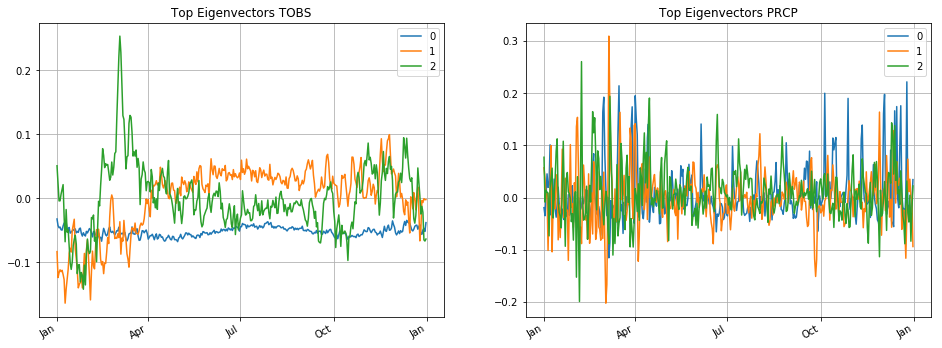

In [17]:
plot_pair(['TOBS','PRCP'],plot_eigen)

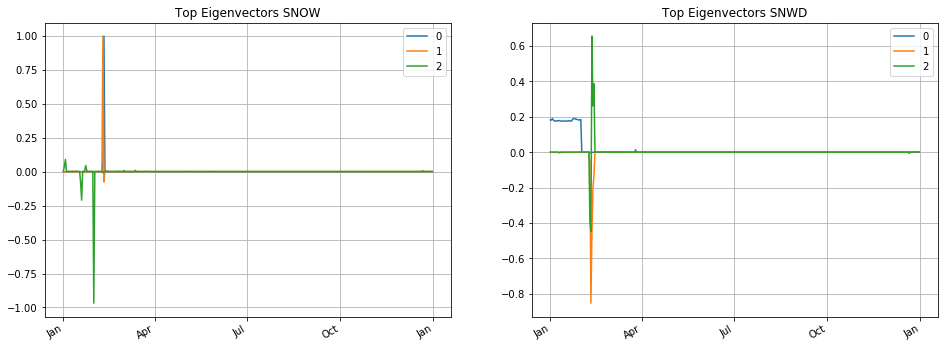

In [18]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [19]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

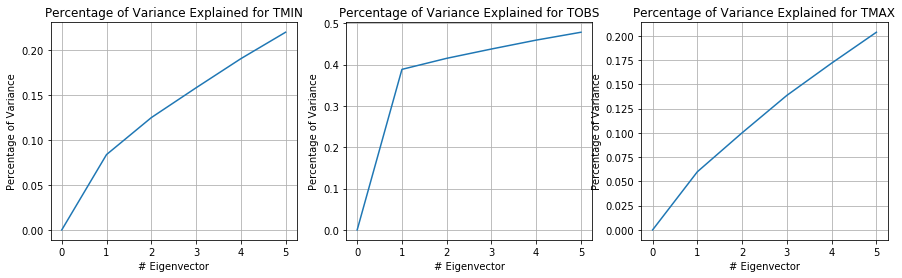

In [20]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

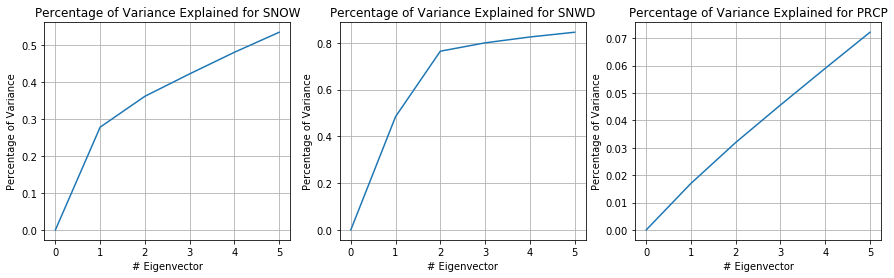

In [21]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [22]:
#sc.stop()